In [47]:
from pymatgen import MPRester, Element, Composition
from pymatgen.phasediagram.analyzer import PhaseDiagram
from pymatgen.phasediagram.entries import PDEntry
from pymatgen.analysis.reaction_calculator import ComputedReaction
import matplotlib.pyplot as plt
import math
import scipy.constants as sc
import numpy as np
import pandas as pnds

In [153]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.font_manager
import matplotlib.patches as patches

# mpl.rcdefaults()

f_size = 18
mpl.rcParams['xtick.labelsize']=f_size
mpl.rcParams['ytick.labelsize']=f_size
mpl.rcParams['axes.labelweight']='light'
mpl.rcParams['axes.labelsize']=f_size
mpl.rcParams['font.size']=f_size
mpl.rcParams['font.family']='sans-serif'
mpl.rcParams['font.sans-serif']='Arial'
mpl.rcParams['font.style']='normal'
mpl.rcParams['font.weight']='light'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'
mpl.rcParams["figure.figsize"] = (8,5)

In [138]:
def temp_to_miu(temp,p_new):
    '''Converts a chemical potential to a temperature (based on O2 only).'''
    #entropies = dict(O2=(205.152/2), SO2=(248.223/3), SO3=(256.77/4), P2O5=(403.96/14), CO2=(213.795/3)) 
                    #gas phase entropy values
    #pressures = dict(O2=0.2, SO2=10**-6, SO3=10**-6, P2O5=10**-8, CO2=0.04) #in atm
    o2_s_blanket = 205.152 #J/k mol
    if temp < 700:
        Ac = 31.32234
        Bc = -20.23531
        Cc = 57.86644
        Dc = -36.50624
        Ec = -0.007374
        Fc = -8.903471
        Gc = 246.7945
    else:
        Ac = 30.03235
        Bc = 8.772972
        Cc = -3.988133
        Dc = 0.788313
        Ec = -0.741599
        Fc = -11.32468
        Gc = 236.1663
    #p_new = 0.1
    p_std = 1
    t = temp/1000.0
    o2_s_temp = Ac*np.log(t) + Bc*t + (Cc/2)*t**2 + (Dc/3)*t**3 - Ec/(2*t**2) + Gc
    o2_h_temp = Ac*t + (Bc/2)*t**2 + (Cc/3)*t**3 + (Dc/4)*t**4 - Ec/t + Fc
    #print o2_s_temp
    #new_miu = ((3.5*sc.k*(temp - 298) - temp*(o2_s_blanket/sc.N_A) + sc.k*temp*math.log(p_new/p_std))/2)/(sc.e)
    new_miu = ((o2_h_temp/sc.N_A - temp*(o2_s_temp/sc.N_A) + sc.k*temp*math.log(p_new/p_std))/2)/(sc.e)
    
    t1 = 0
    
    
    #print new_miu
    return new_miu

In [179]:
print temp_to_miu(273.15+415,0.2)
print temp_to_miu(273.15+50,0.2)

-0.871089819305
-0.369917155987


In [103]:
def get_chempots_phases_enthalpies(chsys, form, elem, binary=None):
    chempots = [] #critical chemical potentials at every transition point
    evolutions = [] 
    phases = []
    enthalpies = []
    reactions = []
    yvec = []
    
    exclusion_list = ['LiS4','S8O']
    
    if binary != None:
        entries, formula, compound = get_binary_entries(chsys, form, binary, elem, 0.5)
        
    else:
        formula = form
        with MPRester() as m:
            entries = m.get_entries_in_chemsys(chsys)
            mpentry = m.get_entries(formula) #gets all MP-entries associated with given composition

        pd = PhaseDiagram(entries) #initialize pd with all metastable entries

        if len(mpentry) == 0: #composition is metastable, so force it to lie on the convex hull
            compound = PDEntry(Composition(formula), 0)
            e0 = pd.get_e_above_hull(compound)
            compound = PDEntry(Composition(formula), -(e0*Composition(formula).num_atoms + 1e-8))
            entries.append(compound)
        else: #otherwise return the most stable entry in the list of MP-entries. This entry can be metastable.
                #in the future, may want to include a shift of "e-above-hull" to set this compound on the x-axis
            mpentry = sorted(mpentry, key=lambda e: e.energy_per_atom)
            compound = mpentry[0]
            entries.append(compound)
    
    entries = [e for e in entries if e.name not in exclusion_list] 
    
    pd = PhaseDiagram(entries) #final pd with entries artificially shifted to hull
    evolution_profile = pd.get_element_profile(Element(elem), Composition(formula))
    ref = evolution_profile[0]['element_reference'].energy_per_atom
    print evolution_profile[0]['element_reference'].energy
    print ref
    
    reac = [compound, evolution_profile[0]['element_reference']]
    
    for stage in evolution_profile: #get chemical potentials and phases
        chempots.append(stage['chempot'] - ref)
        evolutions.append(stage['evolution'])
        namelist = []
        for entry in stage['entries']:
            namelist.append(entry.name)
        phases.append(namelist)
    
    yshift = 0  #initialize y-shift
    window = False #assume the compound has no stability window at first
    
    if binary == None:
        foo, factor = compound.composition.get_reduced_composition_and_factor()
        natoms = compound.composition.num_atoms/factor
    else:
        natoms = 0.5

    for stage in evolution_profile:
        rxn = ComputedReaction(reac, stage['entries']) #calculate reaction enthalpy
        rxn.normalize_to(Composition(formula)) #Composition(evolution_profile[0]['element_reference'].name)
        enthalpies.append(rxn.calculated_reaction_energy) #normalized per F.U. of material / per O2
        reactions.append(str(rxn)) #instead of normalizing to O2 just divide reaction by #O2 in reaction
        if abs(stage['evolution']) < 0.0001: #compound has a stability window
            window = True
            yshift = stage['evolution']*stage['chempot'] + rxn.calculated_reaction_energy
    
    target_H = None
    target_u = -1.133
    for i in range(len(chempots)): #manipulate and shift data for graphs
        #print chempots[i], enthalpies[i]
        ynew = ((evolutions[i]*(-chempots[i]) + enthalpies[i]) - yshift)/natoms #normalize to eV/atom
        yvec.append(ynew)
        enthalpies[i] = (enthalpies[i])/natoms #shift to normalize to eV/atom
        if chempots[i] < target_u and target_H == None: #find enthalpy at target chemical potential
            slope = (yvec[-1] - yvec[-2])/(chempots[i]-chempots[i-1])
            yint = yvec[-1] - slope*chempots[i]
            target_H = slope*target_u + yint
            print 'H at -1.133: ', target_H
    
    return [chempots, phases, yvec, enthalpies, reactions, target_H]

In [44]:
def get_binary_entries(chsys, formula1, formula2, elem, r):
    '''Provides the forumula and entries for a pseudo-binary with ratio r, given the compositions of the two
    constituent compounds.'''
    with MPRester() as m:
        entries = m.get_entries_in_chemsys(chsys)
        mpentries1 = m.get_entries(formula1)
        mpentries2 = m.get_entries(formula2)
        
    pd = PhaseDiagram(entries)
    
    #for each material, check if it exists in the database and return the most stable entry
    if len(mpentries1) != 0: #material exists in database
        mpentries1 = sorted(mpentries1, key=lambda e: e.energy_per_atom)
        m1 = mpentries1[0]
    else: #not in database, make one
        m1 = PDEntry(Composition(formula1), 0)
        e0 = pd.get_e_above_hull(m1)
        m1 = PDEntry(Composition(formula1), -(e0*Composition(formula1).num_atoms))
    entries.append(m1)
    
    if len(mpentries2) != 0:
        mpentries2 = sorted(mpentries2, key=lambda e: e.energy_per_atom)
        m2 = mpentries2[0]
    else:
        m2 = PDEntry(Composition(formula2), 0)
        e0 = pd.get_e_above_hull(m2)
        m2 = PDEntry(Composition(formula2), -(e0*Composition(formula2).num_atoms))
    entries.append(m2)
    
    m1C = Composition(m1.name)
    m2C = Composition(m2.name)
    
    E0 = m1.energy_per_atom * r + m2.energy_per_atom * (1 - r)
    comp = (1/m1C.num_atoms) * r * m1C + (1/m2C.num_atoms) * (1 - r) * m2C
    
    comp_entry = PDEntry(comp, (E0 + 1e-8))
    entries.append(comp_entry)
    
    return entries, comp, comp_entry

In [170]:
LCO = get_chempots_phases_enthalpies(['Mn','P','O'], 'MnPO4','O')
dLCO = get_chempots_phases_enthalpies(['Li','Ni','O'], 'Li0.5NiO2','O')

-39.48422335
-4.93552791875
H at -1.133:  -0.0214532469792
-39.48422335
-4.93552791875
H at -1.133:  -0.134211431518


In [171]:
pnds.options.display.float_format = '{:.3f}'.format

table = pnds.DataFrame({r'$\mu_O$ (eV)':LCO[0],
                      'Phase Equilibria':LCO[1],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':LCO[2],
                        'Reaction':LCO[4]})
pnds.set_option('max_colwidth', 400)

table1 = pnds.DataFrame({r'$\mu_O$ (eV)':dLCO[0],
                      'Phase Equilibria':dLCO[1],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':dLCO[3],
                        'Reaction':dLCO[4]})
display(table)
display(table1)

,$\Delta H_{rxn}$ at $\mu_O$*,$\mu_O$ (eV),Phase Equilibria,Reaction
0,0.000,0.000,[MnPO4],MnPO4 -> MnPO4
1,-0.000,-0.876,[Mn2P2O7],MnPO4 -> 0.25 O2 + 0.5 Mn2P2O7
2,-0.238,-3.736,[MnP],MnPO4 -> 2 O2 + MnP


,$\Delta H_{rxn}$ at $\mu_O$*,$\mu_O$ (eV),Phase Equilibria,Reaction
0,-0.000,0.000,[Li0.5Ni1O2],Li0.5Ni1O2 -> Li0.5Ni1O2
1,0.035,-0.242,"[Li2NiO3, NiO]",Li0.5Ni1O2 -> 0.25 O2 + 0.75 NiO + 0.25 Li2NiO3
2,0.109,-1.035,"[NiO, Li2O]",Li0.5Ni1O2 -> 0.375 O2 + 0.25 Li2O + NiO
3,0.642,-1.868,"[Ni, Li2O]",Li0.5Ni1O2 -> 0.875 O2 + 0.25 Li2O + Ni
4,1.086,-6.213,"[Ni, Li]",Li0.5Ni1O2 -> O2 + 0.5 Li + Ni


Computed oxygen release miu for LCO is -2.644 eV. For delithiated LCO, it is -0.730 eV!

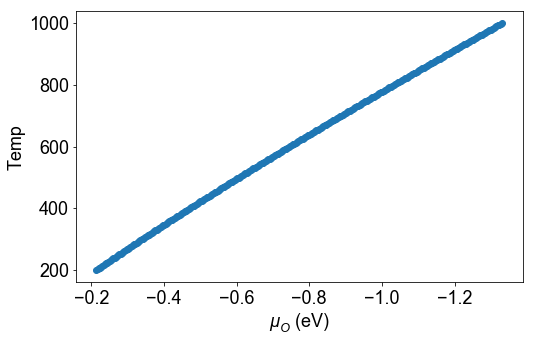

In [155]:
tvec = np.linspace(200, 1000, num=300)
mvec = np.array([])
for temp in tvec:
    mvec = np.append(mvec, temp_to_miu(temp,0.2))

fig, ax = plt.subplots()

ax.set_ylabel(r'Temp')
ax.set_xlabel(r'$\mu_O$ (eV)')

p = plt.plot(mvec, tvec, 'o-')

ax.invert_xaxis()
plt.show()

In [112]:
LCO = get_chempots_phases_enthalpies(['Li','Fe','P','O'], 'LiFePO4','O')


-39.48422335
-4.93552791875
H at -1.133:  -0.0416389583036


In [113]:

table = pnds.DataFrame({r'$\mu_O$ (eV)':LCO[0],
                      'Phase Equilibria':LCO[1],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':LCO[2],
                        'Reaction':LCO[4]})
pnds.set_option('max_colwidth', 400)

display(table)

,$\Delta H_{rxn}$ at $\mu_O$*,$\mu_O$ (eV),Phase Equilibria,Reaction
0,-0.123,0.000,"[Li3Fe2(PO4)3, Fe2O3]",0.25 O2 + LiFePO4 -> 0.1667 Fe2O3 + 0.3333 Li3Fe2(PO4)3
1,0.000,-1.716,[LiFePO4],LiFePO4 -> LiFePO4
2,-0.000,-3.608,"[FeP, Fe2P, Li3PO4]",LiFePO4 -> 1.333 O2 + 0.3333 FeP + 0.3333 Li3PO4 + 0.3333 Fe2P
3,-0.402,-4.663,"[Li2Fe12P7, Li3PO4, FeP]",LiFePO4 -> 1.412 O2 + 0.2941 FeP + 0.2941 Li3PO4 + 0.05882 Li2Fe12P7
4,-0.419,-4.704,[LiFeP],LiFePO4 -> 2 O2 + LiFeP
